- last week we learnt the rolling model
- this week we would learn ensemble methods and intraday trading

In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [2]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [3]:
import warnings
 
warnings.filterwarnings('ignore')

In [4]:
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

In [5]:
period = 4096

In [8]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1066

1066

In [9]:
import dask
from dask import compute, delayed
import sklearn.preprocessing

In [10]:
split_date = "201910"
train_sample = all_dates<split_date
test_sample = all_dates>split_date
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [11]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
n_signal = len(signal_list)

In [12]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV,RidgeCV

from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".004"
#y_signal = "ret."+str(period)

In [13]:
## get multiple samples of the singal matrix
def get_multiple_sample_signal(good_night_files, sample, product, signal_name, period, daily_num, mod=np.array([0])):
    n_samples = int(sum(daily_num[sample])) ## number of samples
    n_mod = len(mod) ## number of different copies of the same signal
    if n_mod==1: ## if there is one copy then the same as before
        all_signal = np.zeros(n_samples)
    else:
        all_signal = np.zeros((n_mod, n_samples)) ## if there are multiple copies then use a matrix for one signal instead
    cur = 0
    for file in good_night_files[sample]: ## iterate for files
        good = load(SAVE_PATH+"/good pkl/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[good]
        for i in range(n_mod):
            signal = S[(np.arange(len(S))+1) % period == mod[i]]
            ## the ret.cor has some bad records
            signal[np.isnan(signal)] = 0
            signal[np.isinf(signal)] = 0
            if mod[i]==0: 
                cur_end = np.min((cur+len(signal),n_samples)) ## to avoid exceed the number of samoes, mod[i]==0 has most signals, 
                ## so if it doesn't exceed, others would not exceed
            if n_mod==1:
                all_signal[cur:cur_end] = signal[0:(cur_end-cur)]
            else:
                all_signal[i, cur:cur_end] = signal[0:(cur_end-cur)]
        cur = cur_end
    return all_signal

In [14]:
mod = np.arange(0, np.floor(period/10)*10, np.floor(period/10))
n_mod = len(mod)
mod
## array([   0.,  409.,  818., 1227., 1636., 2045., 2454., 2863., 3272.,
##        3681.])

array([   0.,  409.,  818., 1227., 1636., 2045., 2454., 2863., 3272.,
       3681.])

In [15]:
SAVE_PATH = "e:/intern"
os.makedirs(SAVE_PATH+"/train test array", exist_ok=True)

In [16]:
%%time
for product in product_list:
    print(product)
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    n_train = sum(daily_num[train_sample])
    n_test = sum(daily_num[test_sample])
    train_array = np.zeros((n_mod, int(n_train), n_signal+1))
    for i in range(n_signal):
        train_array[:,:,i] = get_multiple_sample_signal(all_dates, train_sample, product, signal_list[i], period, daily_num, mod)
    train_array[:,:,n_signal] = get_multiple_sample_signal(all_dates, train_sample, product, "ret."+str(period), period, daily_num, mod)
    save(train_array, SAVE_PATH+"/train test array/"+product+".train.array.pkl")
    
# bu
# ru
# v
# pp
# l
# jd
# Wall time: 1h 5min 5s


bu
ru
v
pp
l
jd
Wall time: 1h 5min 5s


In [17]:
all_train_array = dict([])
for product in product_list:
    all_train_array[product] = load(SAVE_PATH+"/train test array/"+product+".train.array.pkl")

In [18]:
## get the result of 10 models
## save them in to a model_coef dictionary
nfold = 10
model_coef = dict([])
for product in product_list:
    model_coef[product] = np.zeros(n_signal)
for i_mod in range(n_mod):
    train_std_mat = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[product] = model_coef[product]+coef/n_mod


In [19]:
save(model_coef, SAVE_PATH+"/energy.ensemble.model.pkl")

In [20]:
model_coef = load(SAVE_PATH+"/energy.ensemble.model.pkl")

In [21]:
model_coef

# -

{'bu': array([-4.14502155e-04,  4.63891651e-05,  6.74520178e-06, -2.41615432e-04,
        -4.20628658e-05,  1.40455045e-05,  0.00000000e+00, -1.37987174e-05,
        -5.28223035e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.29126444e-05, -1.10053605e-05, -5.28436773e-07, -5.68638814e-04,
         0.00000000e+00,  1.46880597e-06, -4.36460565e-05,  5.12466357e-06,
         5.16084361e-05, -4.50735494e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.83764525e-08,  4.78440243e-06,  0.00000000e+00,
         1.11213186e-03,  0.00000000e+00, -1.02005893e-04, -3.19663874e-03,
         0.00000000e+00,  8.47834499e-02,  5.55104723e-04,  1.09065569e-04,
        -3.35210562e-05,  1.71013375e-04, -4.58883477e-04, -2.22704862e-04,
         0.00000000e+00,  9.27715290e-06,  1.72310473e-02,  0.00000000e+00,
         0.00000000e+00]),
 'ru': array([-5.59917462e-04,  6.64506346e-05,  8.99640439e-06, -3.88050646e-04,
        -4.43649603e-05,  1.39279872e-05,  0.0000

In [22]:
strat = "ensemble.lasso."+str(period)
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [23]:
%%time
for product in product_list:
    print(product)
    coef = model_coef[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")

# bu
# ru
# v
# pp
# l
# jd
# Wall time:  54min 3s



bu
ru
v
pp
l
jd
Wall time: 54min 3s


In [24]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

## Wall time: 5min 10s


Wall time: 5min 10s


In [25]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("ensemble.lasso", all_dates, product, 10, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                    period=4096, split_str=split_date, tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)
    
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# reverse=1
# Wall time: 9min 30s



reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
Wall time: 9min 30s


bu train sharpe  1.546356350356561 test sharpe  0.22264501067782594
ru train sharpe  0.20388873541277389 test sharpe  1.2778865728324549
v train sharpe  1.0109526201580095 test sharpe  0.1689426021443187
pp train sharpe  0.7809247908926406 test sharpe  0.6967920436774366
l train sharpe  0.9770816170811293 test sharpe  0.46471833960785686
jd train sharpe  1.2136183722203686 test sharpe  1.6851569174517522
train sharpe:  1.9679481157900982 test sharpe:  1.2725990123508437


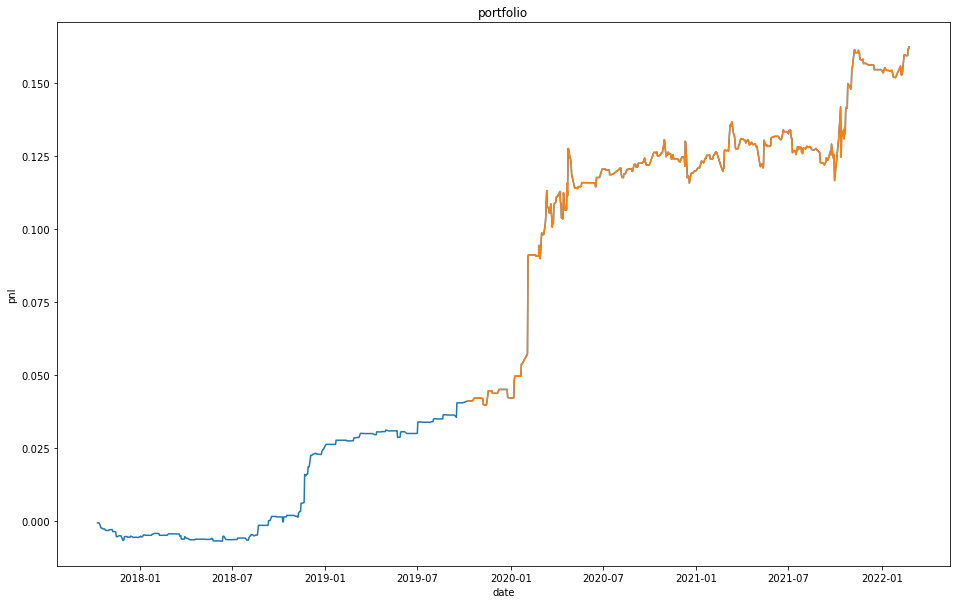

In [26]:
i = 0
strat = "ensemble.lasso.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 0
min_num = 0
for product in product_list:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)==0:
        continue
    train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = signal_stat["test.stat"]
    test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    


# bu train sharpe  1.546356350356561 test sharpe  0.22264501067782594
# ru train sharpe  0.20388873541277389 test sharpe  1.2778865728324549
# v train sharpe  1.0109526201580095 test sharpe  0.1689426021443187
# pp train sharpe  0.7809247908926406 test sharpe  0.6967920436774366
# l train sharpe  0.9770816170811293 test sharpe  0.46471833960785686
# jd train sharpe  1.2136183722203686 test sharpe  1.6851569174517522
# train sharpe:  1.9679481157900982 test sharpe:  1.2725990123508437



- it's not as good as thre model in week 9
- maybe we can use another way of ensemble
- we can generate 10 separate models with each pnl

In [27]:
## generate 10 different models, and save their coefficients rather than calcualte their mean
nfold = 10
model_coef = dict([])
for i_mod in range(n_mod):
    train_std_mat = dict([])
    model_coef[str(i_mod)] = dict([])
    x_train = np.zeros((0, n_signal))
    y_train = np.array([])
    for product in product_list:
        cur_mat = all_train_array[product][i_mod,:,:]
        train_std_mat[product] = np.std(cur_mat, axis=0)
        x_train = np.vstack((x_train, cur_mat[:,:n_signal]/train_std_mat[product][:n_signal]))
        y_train = np.concatenate((y_train, cur_mat[:,n_signal]/train_std_mat[product][n_signal]))
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    scaler.fit(x_train)
    x_std = np.sqrt(scaler.var_)
    x_train_normal = scaler.transform(x_train)
    model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train_normal, y_train)
    fit_coef = model.coef_/x_std
    for product in product_list:
        coef = fit_coef*train_std_mat[product][n_signal]/train_std_mat[product][:n_signal]
        model_coef[str(i_mod)][product] = coef


In [28]:
save(model_coef, SAVE_PATH+"energy.ensemble.all.coef.pkl")

In [29]:
for i_mod in range(n_mod):
    print(i_mod)
    strat = "ensemble.lasso."+str(i_mod)+"."+str(period)
    for product in product_list:
        os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)
        coef = model_coef[str(i_mod)][product]
        parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
                  product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH="e:/intern")
        par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")    
        spread = product_info[product]["spread"]
        tranct = product_info[product]["tranct"]
        tranct_ratio = product_info[product]["tranct.ratio"]
        evaluate_signal("ensemble.lasso."+str(i_mod), all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, "e:/intern",
                        period=4096, split_str=split_date, tranct=tranct, 
                        max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01, save_path="signal result atr",reverse=1)

0
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
2
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
3
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
4
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
5
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
6
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
7
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
8
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
9
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1
reverse=1


In [30]:
min_pnl = 2
min_num = 10
all_portfolio = np.zeros((sum(test_sample)+sum(train_sample),n_mod))
for i_mod in range(n_mod):
    strat = "ensemble.lasso."+str(i_mod)+"."+str(period)
    i = 0
    test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
    train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
    for product in product_list:
        spread = product_info[product]["spread"]
        signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
        train_stat = signal_stat["train.stat"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        if sum(good_strat)==0:
            test_pnl = np.zeros(sum(test_sample))
            train_pnl = np.zeros(sum(train_sample))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
    train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
    test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
    all_portfolio[:,i_mod] = np.append(train_portfolio, test_portfolio)

# bu train sharpe  0.5489039882895194 test sharpe  0.035756796260224454
# ru train sharpe  nan test sharpe  nan
# v train sharpe  0.7094828079689983 test sharpe  -0.6940732865370103
# pp train sharpe  0.5947370391543659 test sharpe  0.8668488469069666
# l train sharpe  nan test sharpe  nan
# jd train sharpe  0.9973234880988134 test sharpe  1.6143824728323808
# bu train sharpe  1.1019423653338876 test sharpe  -0.09531414161480625
# ru train sharpe  0.7343544449825989 test sharpe  1.316177508091726
# v train sharpe  nan test sharpe  nan
# pp train sharpe  1.0714197916559096 test sharpe  0.9459496641327518
# l train sharpe  1.0970894388376606 test sharpe  1.3667419643725067
# jd train sharpe  0.8028583096631081 test sharpe  0.2851761579018249
# bu train sharpe  0.7098928537324402 test sharpe  0.0403157476923578
# ru train sharpe  0.5219911519522007 test sharpe  1.4900749121072536
# v train sharpe  nan test sharpe  nan
# pp train sharpe  0.8448296736387081 test sharpe  0.8755282226343012
# l train sharpe  1.1552572584333103 test sharpe  0.945311276311618
# jd train sharpe  0.7022107963797155 test sharpe  1.2645320871345833
# bu train sharpe  0.7923299331313658 test sharpe  0.7256832206467192
# ru train sharpe  0.5594455655905128 test sharpe  0.35616250029653324
# v train sharpe  0.7009547037560692 test sharpe  -0.48035720115168723
# pp train sharpe  0.16289004659483847 test sharpe  0.6357179844241254
# l train sharpe  0.5969989375028817 test sharpe  0.7210270284478859
# jd train sharpe  0.9938173038137181 test sharpe  1.2179364457483726
# bu train sharpe  1.0557976687440103 test sharpe  0.11489371409482876
# ru train sharpe  0.7118665066024066 test sharpe  1.0511526818645316
# v train sharpe  nan test sharpe  nan
# pp train sharpe  0.3266217691550361 test sharpe  0.9663979788082977
# l train sharpe  0.7772702128987979 test sharpe  0.7798896344597612
# jd train sharpe  0.8008465593804567 test sharpe  1.3289072561899449
# bu train sharpe  0.6213416500092467 test sharpe  0.8065218395765574
# ru train sharpe  nan test sharpe  nan
# v train sharpe  0.5923349075165595 test sharpe  -0.5440789112074171
# pp train sharpe  0.3803257169128198 test sharpe  0.8071260569819073
# l train sharpe  nan test sharpe  nan
# jd train sharpe  0.7239697593496799 test sharpe  1.6936600570785414
# bu train sharpe  0.799918396042945 test sharpe  -0.02615365453595232
# ru train sharpe  0.1735688398083981 test sharpe  0.7553629908967748
# v train sharpe  nan test sharpe  nan
# pp train sharpe  0.6746421207475579 test sharpe  0.787612538158934
# l train sharpe  0.5903741370741186 test sharpe  0.7203882399860521
# jd train sharpe  0.9537595568257756 test sharpe  1.984781287467558
# bu train sharpe  nan test sharpe  nan
# ru train sharpe  nan test sharpe  nan
# v train sharpe  0.6036839084561194 test sharpe  -0.5598932435999636
# pp train sharpe  0.4081905524045088 test sharpe  0.77106859818995
# l train sharpe  nan test sharpe  nan
# jd train sharpe  0.7380055420857123 test sharpe  1.7466381416599714
# bu train sharpe  0.8509892479189388 test sharpe  0.46513347194385296
# ru train sharpe  0.354274050841721 test sharpe  0.06528650321552366
# v train sharpe  0.8814585693804089 test sharpe  -0.8070632288710934
# pp train sharpe  0.4869564970624061 test sharpe  0.24461994968584513
# l train sharpe  0.2994739864124328 test sharpe  0.7912920041913308
# jd train sharpe  1.011280097672203 test sharpe  1.6324265941319092
# bu train sharpe  nan test sharpe  nan
# ru train sharpe  nan test sharpe  nan
# v train sharpe  0.694850107792021 test sharpe  -0.6749046703054666
# pp train sharpe  0.3376671324768046 test sharpe  0.30572813952116273
# l train sharpe  0.532592534699797 test sharpe  1.4058754224095091
# jd train sharpe  1.0182586882692766 test sharpe  1.6647259244589354

bu train sharpe  0.5489039882895194 test sharpe  0.035756796260224454
ru train sharpe  nan test sharpe  nan
v train sharpe  0.7094828079689983 test sharpe  -0.6940732865370103
pp train sharpe  0.5947370391543659 test sharpe  0.8668488469069666
l train sharpe  nan test sharpe  nan
jd train sharpe  0.9973234880988134 test sharpe  1.6143824728323808
bu train sharpe  1.1019423653338876 test sharpe  -0.09531414161480625
ru train sharpe  0.7343544449825989 test sharpe  1.316177508091726
v train sharpe  nan test sharpe  nan
pp train sharpe  1.0714197916559096 test sharpe  0.9459496641327518
l train sharpe  1.0970894388376606 test sharpe  1.3667419643725067
jd train sharpe  0.8028583096631081 test sharpe  0.2851761579018249
bu train sharpe  0.7098928537324402 test sharpe  0.0403157476923578
ru train sharpe  0.5219911519522007 test sharpe  1.4900749121072536
v train sharpe  nan test sharpe  nan
pp train sharpe  0.8448296736387081 test sharpe  0.8755282226343012
l train sharpe  1.155257258433310

train sharpe:  1.9158516845762499 test sharpe:  1.3540844005080486


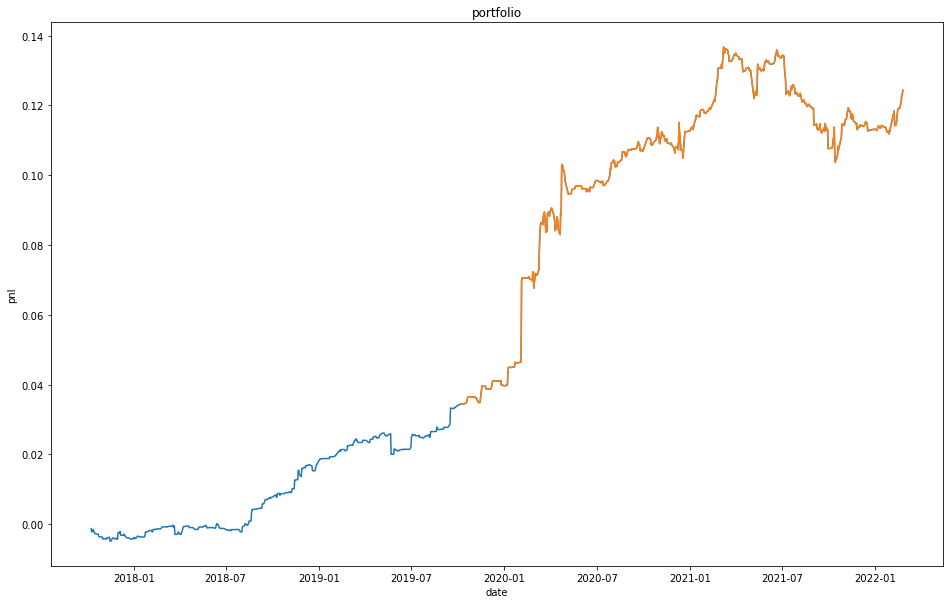

In [31]:
portfolio = np.mean(all_portfolio, axis=1)
train_portfolio = portfolio[train_sample]
test_portfolio = portfolio[test_sample]
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date")
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, portfolio.cumsum());
plt.plot(format_dates[test_sample], portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))   

# train sharpe:  1.9158516845762499 test sharpe:  1.3540844005080486





- we can see that the rolling ensemble model much better than train/test


- now we go for the next part: the intraday medium frequency trading

    
- at this time, we do not need to close position every day
- and we cannot use parallel computing for daily pnl because one day's pnl depends on previous position
- but we can still use parallel for each contract because they are independent


- now let's first find the days of each contract

In [32]:
def get_contract(file):
    data = load(file)
    return data["contract"][data["good"]].iloc[0]

In [33]:
contract_list=dict([])
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    contract_vec = pd.Series(list(map(get_contract, file_list)))
    save(contract_vec, HEAD_PATH+"/"+product+".contract.vec.pkl")
    contract_list[product] = contract_vec

In [34]:
save(contract_list, HEAD_PATH+"/energy.contract.list.pkl")

In [35]:
contract_list = load(HEAD_PATH+"/energy.contract.list.pkl")
product_cum = dict([])
product_len = dict([])
for product in product_list:
    contract_vec = contract_list[product]
    contract_len = contract_vec.value_counts().sort_index()
    contract_cum = contract_len.cumsum()
    product_len[product] = contract_len
    product_cum[product] = contract_cum

- we know that lasso.4096 is trained using data before 2018
- however our contract is not splited in this way
- so we may need to comply to the data of this format

In [36]:
train_sample_list = dict([])
test_sample_list = dict([])
for product in product_list:
    contract_cum = product_cum[product]
    split_date = all_dates[contract_cum[np.max(np.where(all_dates[contract_cum-1]<split_date))]]
    medium_train_sample = (all_dates<split_date)
    medium_test_sample = (all_dates>=split_date)
    train_sample_list[product] = medium_train_sample
    test_sample_list[product] = medium_test_sample

In [37]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [38]:
y_signal = "ret."+str(period)+".004"

In [39]:
train_std = dict([])
all_x_train = dict([])
all_y_train = dict([])
n_sample = 0
for product in product_list:
    medium_train_sample = train_sample_list[product]
    medium_test_sample = test_sample_list[product]
    medium_train_range = range(round(sum((daily_ticks[product][medium_train_sample]))))
    medium_test_range = np.arange(sum(daily_ticks[product][medium_train_sample])+1,sum(daily_ticks[product]))
    medium_train_mat = all_mat[product].iloc[medium_train_range,:]
    medium_test_mat = all_mat[product].iloc[medium_test_range,:]
    x_train = medium_train_mat.iloc[:,:n_signal]
    y_train = medium_train_mat[y_signal]
    train_std[product] = np.std(medium_train_mat)
    all_x_train[product] = x_train
    all_y_train[product] = y_train
    n_sample = n_sample+len(y_train)

In [40]:
x_train = np.zeros((n_sample, n_signal))
y_train = np.zeros(n_sample)
cur = 0
for product in product_list:
    x_train[cur:(cur+len(all_y_train[product])),] = all_x_train[product]/train_std[product][:n_signal]
    y_train[cur:(cur+len(all_y_train[product]))] = all_y_train[product]/train_std[product][y_signal]
    cur = cur+len(all_y_train[product])

In [41]:
model = LassoCV(n_alphas=100, fit_intercept=False, cv=10, max_iter=10000).fit(x_train, y_train)
#model = RidgeCV(fit_intercept=False, cv=5).fit(x_train, y_train)
fit_coef = model.coef_
fit_coef

# array([-0.        ,  0.        ,  0.        , -0.        , -0.        ,
#         0.        , -0.        ,  0.        , -0.        , -0.        ,
#         0.        ,  0.        , -0.00366875, -0.        ,  0.        ,
#        -0.        ,  0.        , -0.        , -0.        ,  0.        ,
#         0.        , -0.        , -0.02536187,  0.        , -0.        ,
#         0.        , -0.        , -0.        , -0.        ,  0.        ,
#        -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
#        -0.        , -0.0185139 ,  0.        ,  0.        , -0.        ,
#         0.        ,  0.01128454,  0.        ,  0.        , -0.        ])

array([-0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.00366875, -0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.02536187,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.0185139 ,  0.        ,  0.        , -0.        ,
        0.        ,  0.01128454,  0.        ,  0.        , -0.        ])

In [42]:
coef_list=dict([])
for product in product_list:
    coef = fit_coef*train_std[product][y_signal]/train_std[product][:n_signal]
    coef_list[product] = coef
    print(product)
    print(coef[coef!=0])

# bu
# dbook.range.4096              -0.000014
# range.pos.std.4096            -0.000144
# trade.imb.trend.index.4096    -0.004248
# price.osci.trend.index.4096    0.000184
# dtype: float64
# ru
# dbook.range.4096              -0.000005
# range.pos.std.4096            -0.000036
# trade.imb.trend.index.4096    -0.006612
# price.osci.trend.index.4096    0.000215
# dtype: float64
# v
# dbook.range.4096              -0.000008
# range.pos.std.4096            -0.000063
# trade.imb.trend.index.4096    -0.004188
# price.osci.trend.index.4096    0.000220
# dtype: float64
# pp
# dbook.range.4096              -0.000011
# range.pos.std.4096            -0.000047
# trade.imb.trend.index.4096    -0.006555
# price.osci.trend.index.4096    0.000180
# dtype: float64
# l
# dbook.range.4096              -0.000007
# range.pos.std.4096            -0.000043
# trade.imb.trend.index.4096    -0.003750
# price.osci.trend.index.4096    0.000158
# dtype: float64
# jd
# dbook.range.4096              -0.000014
# range.pos.std.4096            -0.000109
# trade.imb.trend.index.4096    -0.005678
# price.osci.trend.index.4096    0.000200
# dtype: float64

bu
dbook.range.4096              -0.000014
range.pos.std.4096            -0.000144
trade.imb.trend.index.4096    -0.004248
price.osci.trend.index.4096    0.000184
dtype: float64
ru
dbook.range.4096              -0.000005
range.pos.std.4096            -0.000036
trade.imb.trend.index.4096    -0.006612
price.osci.trend.index.4096    0.000215
dtype: float64
v
dbook.range.4096              -0.000008
range.pos.std.4096            -0.000063
trade.imb.trend.index.4096    -0.004188
price.osci.trend.index.4096    0.000220
dtype: float64
pp
dbook.range.4096              -0.000011
range.pos.std.4096            -0.000047
trade.imb.trend.index.4096    -0.006555
price.osci.trend.index.4096    0.000180
dtype: float64
l
dbook.range.4096              -0.000007
range.pos.std.4096            -0.000043
trade.imb.trend.index.4096    -0.003750
price.osci.trend.index.4096    0.000158
dtype: float64
jd
dbook.range.4096              -0.000014
range.pos.std.4096            -0.000109
trade.imb.trend.index.4096   

- here we use ridge because lasso is not good

In [43]:
strat = "energy.lasso.medium."+str(period)
#strat = "ridge.medium."+str(period)
SAVE_PATH = "e:/intern"

In [44]:
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [45]:
%%time
for product in product_list:
    print(product)
    coef = coef_list[product]
    parLapply(CORE_NUM, all_dates, par_get_daily_pred, 
              product=product, coef=coef, strat=strat, HEAD_PATH="e:/intern", SAVE_PATH=SAVE_PATH)

#bu
#ru
#v
#pp
#l
#jd
#Wall time: 56min 25s




bu
ru
v
pp
l
jd
Wall time: 56min 25s


In [46]:
%%time
for product in product_list:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

#Wall time: 6min 6s

Wall time: 5min 49s


In [47]:
close_thre_list = dict([])
for product in product_list:
    all_signal = load(SAVE_PATH+"/all signal/"+product+"."+strat+".pkl")
    open_thre = np.quantile(abs(all_signal), np.concatenate((np.arange(0.991, 0.999, 0.001),
                                                         np.arange(0.9991,0.9999,0.0001)),axis=0))
    thre_mat = pd.DataFrame(data=OrderedDict([("open", open_thre), ("close", -open_thre)]))
    from collections import OrderedDict
    import itertools
    open_list=open_thre
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    close_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    close_thre_list[product] = close_thre_mat


In [48]:
contract_vec = dict([])
contract_start = dict([])
for product in product_list:
    contract_vec[product] = np.array(product_cum[product].index)
    contract_start[product] = np.hstack((0, product_cum[product].values))


In [49]:
## backtest strategy within a contract
## need not to close position at the end of day
## need to get the position at the end of day and calculate the overnight holding pnl
def get_signal_pnl_contract(contract, contract_vec, good_night_files, product, signal_name, thre_mat, 
                                    slippage=1, fee=0.1, reverse=1, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    file_list = good_night_files[contract_vec==contract]
    n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    ## load product info
    tranct = product_info[product]["tranct"]*(1+fee)
    close = product_info[product]["close"]*(1+fee)
    min_spread = product_info[product]["spread"]+0.1
    spread = product_info[product]["spread"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    
    yesterday_pos = np.repeat(0, n_thre)
    yesterday_notional = np.repeat(0., n_thre)
    yesterday_price = 0.
    n_day = len(file_list)
    daily_pnl = np.zeros((n_day, n_thre))
    daily_ret = np.zeros((n_day, n_thre))
    for i_day in range(n_day):
        file = file_list[i_day]
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        data = data[data["good"]].reset_index(drop=True)
        n_bar = len(data)
        ## load signal
        ## we don't know the signal is positive correlated or negative correlated  
        pred = S*reverse
        
        bid_ask_spread = data["ask"]-data["bid"]
        next_spread = bid_ask_spread.shift(-1)
        next_spread.iloc[-1] = bid_ask_spread.iloc[-1]
        #not_trade = (data["time"]=="10:15:00") | (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
        not_trade = (data["time"]=="11:30:00") | (data["time"]=="15:00:00") | (bid_ask_spread>min_spread) | (next_spread>min_spread)
            
        next_ask = data["next.ask"].values
        next_bid = data["next.bid"].values
          
        i_thre = 0 
        for thre in thre_mat.values:
            buy = pred>thre[0]
            sell = pred<-thre[0]
            signal = pd.Series(data=0, index=data.index)
            #position = signal.copy()
            signal[buy] = 1
            signal[sell] = -1
            signal[not_trade] = 0
            scratch = -thre[1]
            position_pos = pd.Series(data=np.nan, index=data.index)
            position_pos[(signal==1) & (next_ask>0) & (next_bid>0)] = 1
            position_pos[(pred< -scratch) & (next_bid>0)] = 0
            position_pos.iloc[0] = max((0, yesterday_pos[i_thre]))
            position_pos.ffill(inplace=True)
            pre_pos = position_pos.shift(1)
            notional_position_pos = pd.Series(data=np.nan, index=data.index)
            notional_position_pos[position_pos==1] = 1
            notional_position_pos[0] = np.nan
            notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
            notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
            notional_position_pos[(pred< -scratch) & (next_bid>0)] = 0
            notional_position_pos.iloc[0] = max((0, yesterday_notional[i_thre]))
            notional_position_pos.ffill(inplace=True)
            position_neg = pd.Series(data=np.nan, index=data.index)
            position_neg[(signal==-1) & (next_ask>0) & (next_bid>0)] = -1
            position_neg[(pred> scratch) & (next_ask>0)] = 0
            position_neg.iloc[0] = min((yesterday_pos[i_thre], 0))
            position_neg.ffill(inplace=True)
            pre_neg = position_neg.shift(1)
            notional_position_neg = pd.Series(data=np.nan, index=data.index)
            notional_position_neg[position_neg==-1] = -1
            notional_position_neg[0] = np.nan
            notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
            notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
            notional_position_neg[(pred> scratch) & (next_ask>0)] = 0
            notional_position_neg.iloc[0] = min((yesterday_notional[i_thre], 0))
            notional_position_neg.ffill(inplace=True)
            position = position_pos + position_neg
            notional_position = notional_position_pos+notional_position_neg
            position.loc[0] = yesterday_pos[i_thre]
            notional_position[0] = yesterday_notional[i_thre]
            if file == file_list[-1]:
                position.iloc[-10:] = 0
                notional_position.iloc[-10:] = 0
            else:
                position.iloc[-10:] = position.iloc[-10]
                notional_position.iloc[-10:] = notional_position.iloc[-10]
            initial_pnl = yesterday_pos[i_thre]*yesterday_price
            initial_notional_pnl = yesterday_notional[i_thre]*yesterday_price
            change_pos = position - position.shift(1)
            change_pos.iloc[0] = 0
            notional_change_pos = notional_position-notional_position.shift(1)
            notional_change_pos.iloc[0] = 0
            pre_pos = position.shift(1)
            pre_pos.iloc[0] = position.iloc[0]
            change_base = pd.Series(data=0, index=data.index)
            change_buy = change_pos>0
            change_sell = change_pos<0
            if (tranct_ratio):
                change_base[change_buy] = (data["next.ask"][change_buy]+spread*slippage)*(1+tranct)
                change_base[change_sell] = (data["next.bid"][change_sell]-spread*slippage)*(1-tranct)
            else:
                change_base[change_buy] = data["next.ask"][change_buy]+tranct+spread*slippage
                change_base[change_sell] = data["next.bid"][change_sell]-tranct-spread*slippage
            notional_change_base = pd.Series(data=0, index=data.index)
            notional_change_buy = notional_change_pos>0
            notional_change_sell = notional_change_pos<0
            if (tranct_ratio):
                notional_change_base[notional_change_buy] = (data["next.ask"][notional_change_buy]+spread*slippage)*(1+tranct)
                notional_change_base[notional_change_sell] = (data["next.bid"][notional_change_sell]-spread*slippage)*(1-tranct)
            else:
                notional_change_base[notional_change_buy] = data["next.ask"][notional_change_buy]+tranct+spread*slippage
                notional_change_base[notional_change_sell] = data["next.bid"][notional_change_sell]-tranct-spread*slippage

            yesterday_pos[i_thre] = position.iloc[-1]
            yesterday_notional[i_thre] = notional_position.iloc[-1]
            final_pnl = -sum(change_base*change_pos)+data["price"].iloc[-1]*yesterday_pos[i_thre]-initial_pnl
            daily_pnl[i_day, i_thre] = final_pnl
            ## add the overnight pnl
            ret = -sum(notional_change_base*notional_change_pos)+data["price"].iloc[-1]*yesterday_notional[i_thre]-initial_notional_pnl
            daily_ret[i_day, i_thre] = ret
            num = sum((position!=0) & (change_pos!=0))
            result.loc[i_thre, ("num")] = result.loc[i_thre, ("num")]+num
            result.loc[i_thre, ("pnl")] = result.loc[i_thre, ("pnl")]+final_pnl
            result.loc[i_thre, ("ret")] = result.loc[i_thre, ("ret")]+ret
            if result.loc[i_thre, ("num")] == 0:
                result.loc[i_thre, ("avg.pnl")] = 0
                result.loc[i_thre, ("avg.ret")] = 0
            else:
                result.loc[i_thre, ("avg.pnl")] = np.divide(result.loc[i_thre, ("pnl")], result.loc[i_thre, ("num")])
                result.loc[i_thre, ("avg.ret")] = np.divide(result.loc[i_thre, ("ret")], result.loc[i_thre, ("num")])
            i_thre = i_thre + 1
        yesterday_price = data["price"].iloc[-1]
    os.makedirs(SAVE_PATH+"/medium strat/"+product+"/"+signal_name, exist_ok=True)
    save((result, daily_pnl, daily_ret), SAVE_PATH+"/medium strat/"+product+"/"+signal_name+"/"+contract+".pkl")

In [50]:
%%time
for product in product_list:
    print(product)
    result = parLapply(CORE_NUM, contract_vec[product], get_signal_pnl_contract, 
                       contract_vec=contract_list[product], good_night_files=all_dates, product=product, 
                       signal_name=strat, thre_mat=close_thre_list[product])

# bu
# ru
# v
# pp
# l
# jd
# Wall time: 4h 31min 38s



bu
ru
v
pp
l
jd
Wall time: 4h 31min 38s


- then we can select good signals from training samples

In [51]:
train_contract_list = dict([])
test_contract_list = dict([])
for product in product_list:
    last_contract = contract_list[product][np.max(np.where(train_sample_list[product]))]
    train_contract_list[product] = contract_vec[product][contract_vec[product]<=last_contract]
    test_contract_list[product] = contract_vec[product][contract_vec[product]>last_contract]

In [52]:
train_stat_list = dict([])
for product in product_list:
    train_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    train_contract = train_contract_list[product]
    for contract in train_contract:
        (result, daily_pnl, daily_ret) = load(SAVE_PATH+"/medium strat/"+product+"/"+strat+"/"+contract+".pkl")
        if train_stat["final.result"] is None:
            train_stat["final.result"] = result
        else:
            train_stat["final.result"]["num"] = train_stat["final.result"]["num"] + result["num"]
            train_stat["final.result"]["pnl"] = train_stat["final.result"]["pnl"] + result["pnl"]
            train_stat["final.result"]["ret"] = train_stat["final.result"]["ret"] + result["ret"]
            train_stat["final.result"]["avg.pnl"] = zero_divide(train_stat["final.result"]["pnl"], train_stat["final.result"]["num"])
            train_stat["final.result"]["avg.ret"] = zero_divide(train_stat["final.result"]["ret"], train_stat["final.result"]["num"])

        if train_stat["daily.ret"] is None:
            train_stat["daily.ret"] = daily_ret
        else:
            train_stat["daily.ret"] = np.vstack((train_stat["daily.ret"], daily_ret))
    train_stat_list[product] = train_stat

In [53]:
test_stat_list = dict([])
for product in product_list:
    test_stat = OrderedDict([("final.result", None), ("daily.ret", None)])
    test_contract = test_contract_list[product]
    for contract in test_contract:
        (result, daily_pnl,daily_ret) = load(SAVE_PATH+"/medium strat/"+product+"/"+strat+"/"+contract+".pkl")
        if test_stat["final.result"] is None:
            test_stat["final.result"] = result
        else:
            test_stat["final.result"]["num"] = test_stat["final.result"]["num"] + result["num"]
            test_stat["final.result"]["pnl"] = test_stat["final.result"]["pnl"] + result["pnl"]
            test_stat["final.result"]["ret"] = test_stat["final.result"]["ret"] + result["ret"]
            test_stat["final.result"]["avg.pnl"] = zero_divide(test_stat["final.result"]["pnl"], test_stat["final.result"]["num"])
            test_stat["final.result"]["avg.ret"] = zero_divide(test_stat["final.result"]["ret"], test_stat["final.result"]["num"])

        if test_stat["daily.ret"] is None:
            test_stat["daily.ret"] = daily_ret
        else:
            test_stat["daily.ret"] = np.vstack((test_stat["daily.ret"], daily_ret))
    test_stat_list[product] = test_stat

In [54]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 2
min_num = 10
for product in product_list:
    spread = product_info[product]["spread"]
    train_stat = train_stat_list[product]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    train_pnl = train_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    test_stat = test_stat_list[product]
    test_pnl = test_stat["daily.ret"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1

# bu train sharpe  0.43259387467716853 test sharpe  -0.15893656952420557
# ru train sharpe  0.7766989556526774 test sharpe  0.019123148438340076
# v train sharpe  1.34646080453167 test sharpe  -1.0120043216644137
# pp train sharpe  1.4989938722692804 test sharpe  1.1074064893579825
# l train sharpe  0.7178219619998605 test sharpe  0.25340392860895455
# jd train sharpe  nan test sharpe  nan





bu train sharpe  0.43259387467716853 test sharpe  -0.15893656952420557
ru train sharpe  0.7766989556526774 test sharpe  0.019123148438340076
v train sharpe  1.34646080453167 test sharpe  -1.0120043216644137
pp train sharpe  1.4989938722692804 test sharpe  1.1074064893579825
l train sharpe  0.7178219619998605 test sharpe  0.25340392860895455
jd train sharpe  nan test sharpe  nan


- we can see that the test result accpetable even though there is a small drawback
